In [1]:
# import needed packages
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

# Reading BIPED Dataset (https://www.kaggle.com/xavysp/biped)

In [2]:
# file path of downloaded biped dataset
train_path_img = "biped/BIPEDv2/BIPEDv2/BIPED/edges/imgs/train/rgbr/real/"
train_path_edges = "biped/BIPEDv2/BIPEDv2/BIPED/edges/edge_maps/train/rgbr/real/"
train_filenames = [name.strip(".jpg") for name in os.listdir(train_path_img)]

test_path_img = "biped/BIPEDv2/BIPEDv2/BIPED/edges/imgs/test/rgbr/"
test_path_edges = "biped/BIPEDv2/BIPEDv2/BIPED/edges/edge_maps/test/rgbr/"
test_filenames = [name.strip(".jpg") for name in os.listdir(test_path_img)]

# load pixels RGB matrix
X_train = [cv.imread(train_path_img+path+".jpg") for path in train_filenames] 
y_train = [cv.imread(train_path_edges+path+".png") for path in train_filenames] 
X_test = [cv.imread(test_path_img+path+".jpg") for path in test_filenames] 
y_test = [cv.imread(test_path_edges+path+".png") for path in test_filenames] 

# y objects are grey images, no need to be h x w x 3
y_train = [y[:,:,0] for y in y_train]
y_test = [y[:,:,0] for y in y_test]

print("Train dataset size: " + str(len(X_train)) + '/' + str(len(X_train)+len(X_test)) + '.')
print("Test dataset size: " + str(len(X_test)) + '/' + str(len(X_train)+len(X_test)) + '.')
print("X image shape: ",X_train[0].shape)
print("y image shape: ",y_train[0].shape)

Train dataset size: 200/250.
Test dataset size: 50/250.
X image shape:  (720, 1280, 3)
y image shape:  (720, 1280)


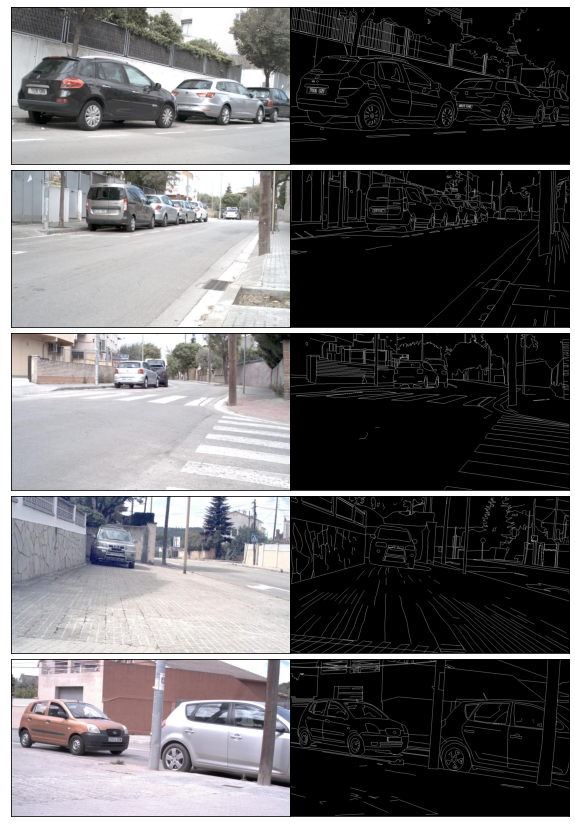

In [3]:
# plot some of these images
n = 5
fig, axs = plt.subplots(n, 2, figsize=(10,3*n), gridspec_kw = {'wspace':0, 'hspace':0})
for i in range(0,n):
    # mentioning absolute path of the image
    img_path1 = train_path_img+train_filenames[i]+".jpg"
    img_path2 = train_path_edges+train_filenames[i]+".png"

    # read/load an image
    image1 = cv.imread(img_path1)
    image2 = cv.imread(img_path2)
    
    # they are on BGR instead of RGB
    image1 = np.concatenate([image1[:,:,2].reshape((720,1280,1)),
                             image1[:,:,1].reshape((720,1280,1)),
                             image1[:,:,0].reshape((720,1280,1))],axis=2)
    image2 = np.concatenate([image2[:,:,2].reshape((720,1280,1)),
                             image2[:,:,1].reshape((720,1280,1)),
                             image2[:,:,0].reshape((720,1280,1))],axis=2)

    # show the input image on the newly created image window
    imgplot1 = axs[i][0].imshow(image1)
    imgplot2 = axs[i][1].imshow(image2)
    
    axs[i][0].set_xticks([])
    axs[i][0].set_yticks([])
    axs[i][1].set_xticks([])
    axs[i][1].set_yticks([])

# Setting Canny Method

In [4]:
# transform a grey image data into RGB
def toRGB(image):
    return np.concatenate(3*[image.reshape((image.shape[0],image.shape[1],1))], axis = 2)

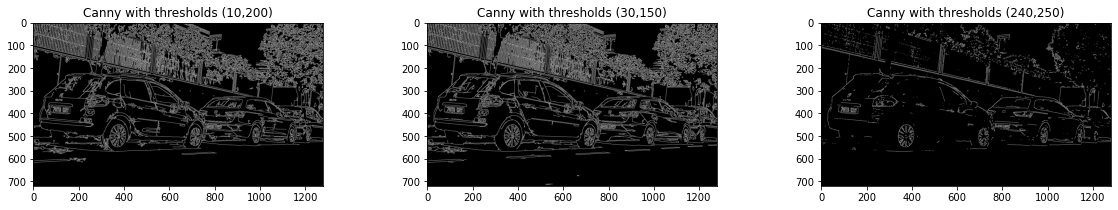

In [5]:
# using the Canny edge detector
wide = cv.Canny(X_train[0], 10, 200)
mid = cv.Canny(X_train[0], 30, 150)
tight = cv.Canny(X_train[0], 240, 250)

# show the output Canny edge maps
fig, axs = plt.subplots(1, 3, figsize=(20,3))
axs[0].imshow(toRGB(wide), cmap = 'Greys')
axs[0].set_title('Canny with thresholds ('+str(10)+','+str(200)+')')
axs[1].imshow(toRGB(mid), cmap = 'Greys')
axs[1].set_title('Canny with thresholds ('+str(30)+','+str(150)+')')
axs[2].imshow(toRGB(tight), cmap = 'Greys')
axs[2].set_title('Canny with thresholds ('+str(240)+','+str(250)+')')
plt.show()

In [6]:
# get our predictions
y_pred_canny_wide = [cv.Canny(x,10,200) for x in X_test]
y_pred_canny_mid = [cv.Canny(x,30,150) for x in X_test]
y_pred_canny_tight = [cv.Canny(x,240,250) for x in X_test]

# Using CNN's to Detect Edges

## Loading already trained HED
### Source: https://github.com/legolas123/cv-tricks.com/tree/master/OpenCV/Edge_detection

In [7]:
# One of the layers dont belong to basic CV package, so we need to bind it
class CropLayer(object):
    def __init__(self, params, blobs):
        self.xstart = 0
        self.xend = 0
        self.ystart = 0
        self.yend = 0

    # Our layer receives two inputs. We need to crop the first input blob
    # to match a shape of the second one (keeping batch size and number of channels)
    def getMemoryShapes(self, inputs):
        inputShape, targetShape = inputs[0], inputs[1]
        batchSize, numChannels = inputShape[0], inputShape[1]
        height, width = targetShape[2], targetShape[3]

        self.ystart = (inputShape[2] - targetShape[2]) // 2
        self.xstart = (inputShape[3] - targetShape[3]) // 2
        self.yend = self.ystart + height
        self.xend = self.xstart + width

        return [[batchSize, numChannels, height, width]]

    def forward(self, inputs):
        return [inputs[0][:,:,self.ystart:self.yend,self.xstart:self.xend]]

In [8]:
# Binding it
cv.dnn_registerLayer('Crop', CropLayer)

In [9]:
# Load the HED model. Download the deploy and the pretrained object from the link
net = cv.dnn.readNet('deploy.prototxt.txt', 'hed_pretrained_bsds.caffemodel')

In [10]:
# Check amount of parameters
layerNames = net.getLayerNames()
params = []
for name in layerNames:
    try:
        params.append(net.getParam(name).ravel().shape[0])
    except:
        pass
print('Total number of parameters: ',np.sum(params))

Total number of parameters:  14713301


In [11]:
# Function of input of the net
def input_CNN(image):
    inp = cv.dnn.blobFromImage(image, scalefactor=1.0, size=(500, 500),
                               mean=(104.00698793, 116.66876762, 122.67891434),
                               swapRB=False, crop=False)
    net.setInput(inp)
    outG = net.forward()
    outG = outG[0, 0]
    outG = cv.resize(outG, (image.shape[1], image.shape[0]))
    outG = 255 * outG
    outG = outG.astype(np.uint8)
    return outG

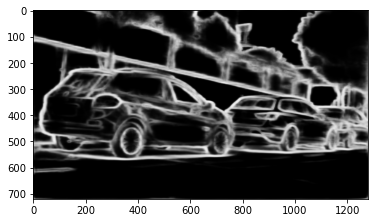

In [12]:
# Test with an image
y1 = input_CNN(X_train[0])
plt.imshow(toRGB(y1),cmap='Greys');

In [13]:
# Get our predictions
y_pred_cnn = [input_CNN(x) for x in X_test]

# Image results checking

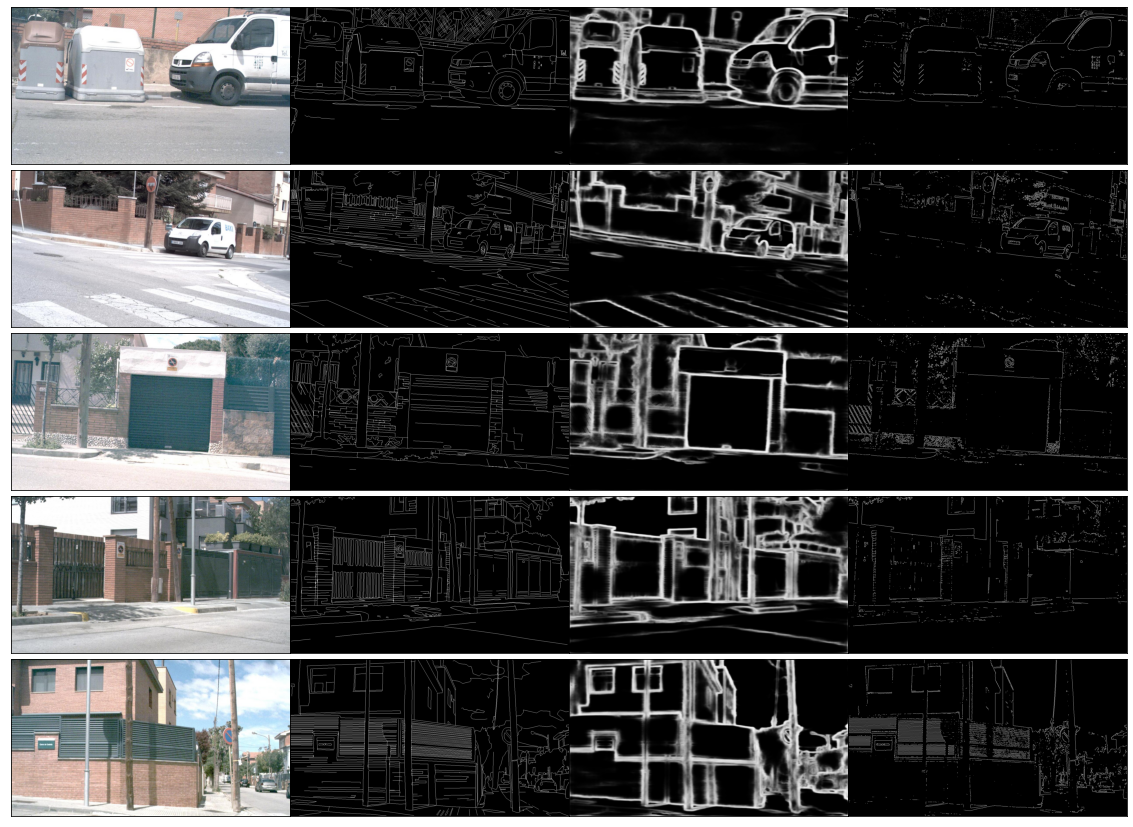

In [14]:
# Checking the results
n = 5
fig, axs = plt.subplots(n, 4, figsize=(20,3*n), gridspec_kw = {'wspace':0, 'hspace':0})
for i in range(0,n):
    # read/load an image
    image = X_test[i]
    
    # they are on BGR instead of RGB
    image = np.concatenate([image[:,:,2].reshape((720,1280,1)),
                            image[:,:,1].reshape((720,1280,1)),
                            image[:,:,0].reshape((720,1280,1))],axis=2)

    for j in range(0,4):
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        
    # show the input image on the newly created image window
    imgplot1 = axs[i][0].imshow(image)
    imgplot2 = axs[i][1].imshow(toRGB(y_test[i]), cmap='Greys')
    imgplot3 = axs[i][2].imshow(toRGB(y_pred_cnn[i]), cmap='Greys')
    imgplot4 = axs[i][3].imshow(toRGB(y_pred_canny_tight[i]), cmap='Greys')
    
plt.show()